# Homework #6: Decision Trees and Random Forests

A bank is interested in reaching out to customers directly (via phone) to solicit subscriptions to a new product they are planning to offer. The company has over 45k customers and only a small number of phone agents to contact them so targeting those that are most likely to subscribe will maximize their return on investment.

Prior to contacting them, they have asked their Data Science team to analyze customer characteristics for a similar product campaign they ran in the previous year. Your goal is to construct an effective tree-based model to predict whether a customer will subscribe or not.

### Relevant Dataset
`bank-full.csv`
* Response Variable: `y`

### Source of data: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

## Task 1: Import data and construct a random 70/15/15 train/val/test split. Make sure to dummy code categorical variables.

In [78]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs, make_circles, make_classification
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import pandas as pd

%matplotlib inline

In [16]:
df = pd.read_csv("/content/bank-full.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [17]:
splits = np.random.choice(a = 3, size = df.shape[0], p = [0.7,0.15,0.15])
df = pd.get_dummies(data=df, drop_first=True)

In [46]:
Counter(df.y_yes)

Counter({0: 39922, 1: 5289})

In [48]:
39922/(39922+5289)

0.8830151954170445

In [18]:
df_train = df.iloc[np.where(splits == 0)[0],:]
df_val = df.iloc[np.where(splits == 1)[0],:]
df_test = df.iloc[np.where(splits == 2)[0],:]

In [20]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(31694, 43)
(6772, 43)
(6745, 43)


In [19]:
df_train.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,y_yes
2,33,2,5,76,1,-1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
6,28,447,5,217,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
8,58,121,5,50,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
9,43,593,5,55,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
11,29,390,5,137,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [21]:
xtrain = df_train.iloc[:,:-1]
ytrain = df_train.iloc[:,-1]
xtest = df_test.iloc[:,:-1]
ytest = df_test.iloc[:,-1]

In [22]:
xval = df_val.iloc[:,:-1]
yval = df_val.iloc[:,-1]

## Task 2: Use Cost-Complexity Pruning to find the optimal depth for a Decision Tree Classifier.

Note: "Optimal" is subjective. Feel free to choose a shallower more interpretable tree or a slightly deeper more accurate tree. Simply explain why you chose the depth you did.

In [29]:
clf = DecisionTreeClassifier().fit(xtrain, ytrain)
train_acc = clf.score(xtrain,ytrain)
test_acc = clf.score(xtest, ytest)

print(f'Training Accuracy: {train_acc}')
print(f'Test Accuracy: {test_acc}')


Training Accuracy: 1.0
Test Accuracy: 0.8698295033358043


Text(0, 0.5, 'total impurity of leaves')

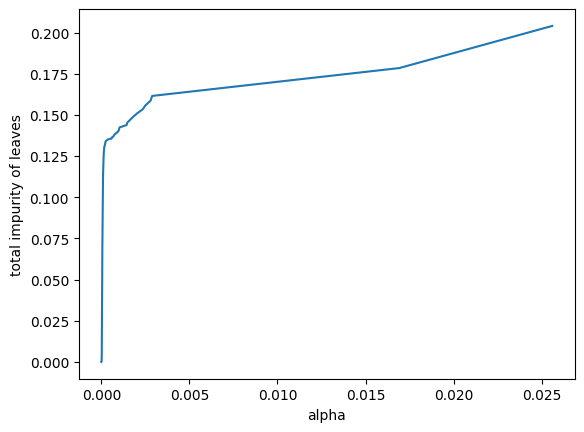

In [28]:
path = clf.cost_complexity_pruning_path(xtrain, ytrain)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.plot(ccp_alphas, impurities)
plt.xlabel("alpha")
plt.ylabel("total impurity of leaves")

In [34]:
ccp_alphas.shape

(1092,)

Text(0, 0.5, 'total depth')

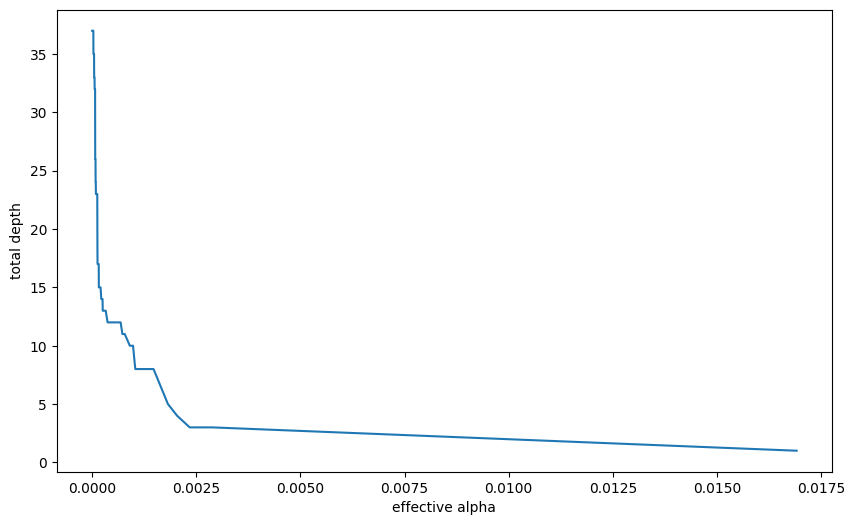

In [35]:
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(xtrain, ytrain)
    clfs.append(clf)
    
tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")

Text(0, 0.5, 'Accuracy scores')

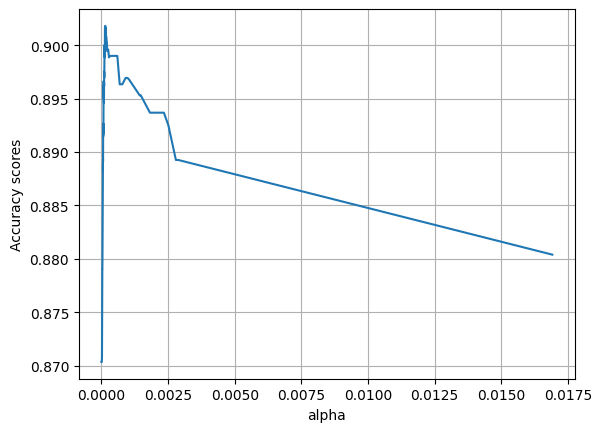

In [37]:
acc_scores = [clf.score(xval, yval) for clf in clfs]

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("alpha")
plt.ylabel("Accuracy scores")

In [51]:
len(clfs)

1092

In [68]:
clfs[-15]

DecisionTreeClassifier(ccp_alpha=0.000726238179997233, random_state=0)

In [69]:
min_depth_clf = clfs[-15]

In [70]:
optimal_clf = min_depth_clf

train_acc = optimal_clf.score(xtrain,ytrain)
test_acc = optimal_clf.score(xtest, ytest)

print(f'Training Accuracy: {train_acc}')
print(f'Test Accuracy: {test_acc}')


Training Accuracy: 0.9049031362402978
Test Accuracy: 0.900074128984433


Based on the depth and accuracy scores graph, I wanted to find an accuracy score value close to the max but not have as much depth to have better interpretability. I wanted to get an alpha of value of .00625 which is 1/4 from the maximum accuracy score. The 15 from the end of the list had a value of .0007 which was very close to my desired alpha value.  It also had a higher accuracy than the baseline of .883 with a value of .904

## Task 3: Visualize the "Optimal" tree you fit and interpret the first few splits to the best of your ability.

In [72]:
plt.figure(figsize=(150, 100))
plot_tree(optimal_clf)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

x[3] and x[40] were split on multiple times and have the most influence on our dataset. x[3] ranges from 126 to 836.5.

## Task 4: Calculate the k-fold CV accuracy for predicting 'yes' or 'no' using a Decision Tree Classifier.

In [76]:

decision_tree_model = DecisionTreeClassifier(criterion="gini",
                                     random_state=0)
decision_tree_result = cross_val_score(decision_tree_model, xval, yval, cv = len(clfs))
print(decision_tree_result)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 810 members, which is less than n_splits=1092.
  warnings.warn(


[1.         0.85714286 0.85714286 ... 0.66666667 0.33333333 0.66666667]


## Task 5: Fit a Random Forest Classifier and use the OOB accuracy to choose the optimal number of trees and/or variables sampled at each split.

Note: The argument for number of trees is `n_estimators` in scikit-learn and the number of variables to consider at each split is `max_features`.

[0.8846784880419006, 0.9023789991796555, 0.9056603773584906, 0.9033255505773964, 0.9054079636524264, 0.903988136555815]


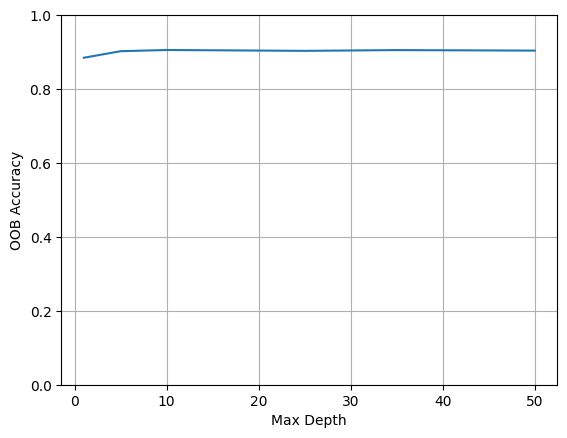

In [81]:
max_depth = [1,5,10,25,35,50]

oob_acc = []
for n in max_depth:
    clf = RandomForestClassifier(n_estimators=100,
                                 max_depth=n,
                                 max_features=43,
                                 oob_score=True)
    clf.fit(xtrain,ytrain)
    oob_acc.append(clf.oob_score_)

plt.grid()
plt.ylim([0, 1.0])
plt.plot(max_depth, oob_acc)
plt.xlabel("Max Depth")
plt.ylabel("OOB Accuracy")
print(oob_acc)

## Task 6: Report impurity based feature importance for your final selected model in a bar chart. 

Optional: If you are curious, try running permutation importance (note: this may take a while) and compare the two

In [92]:
columns = list(df)
columns.pop()
print(columns)

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_married', 'marital_single', 'education_secondary', 'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone', 'contact_unknown', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']


In [82]:
clf.oob_score_

0.903988136555815

In [83]:
clf.feature_importances_

array([0.09469691, 0.1100573 , 0.08203161, 0.28256994, 0.03290244,
       0.04205679, 0.01574572, 0.00818198, 0.00297303, 0.00314922,
       0.00870748, 0.0030378 , 0.00441318, 0.00565295, 0.00519928,
       0.01046157, 0.00484254, 0.00168747, 0.01038837, 0.00774118,
       0.00899163, 0.00940615, 0.00523666, 0.00184148, 0.01679702,
       0.00772192, 0.00561598, 0.01424965, 0.00874129, 0.00278685,
       0.00792054, 0.00488394, 0.00883832, 0.01216788, 0.013639  ,
       0.01002165, 0.00907284, 0.01163718, 0.00789892, 0.0031451 ,
       0.09065146, 0.00223778])

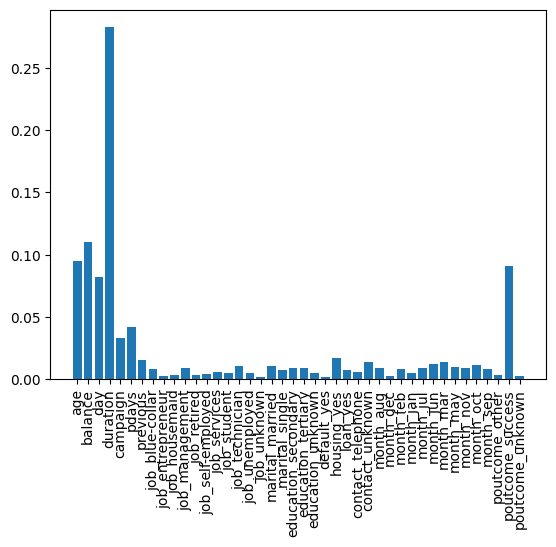

In [93]:
plt.bar(x = columns[:],height=clf.feature_importances_)
plt.xticks(rotation = 90)
plt.show()

## Task 7: Choose the model with the best cross-validated or OOB accuracy between Decision Trees and Random Forests and provide the Partial Dependence Plots for the 5 most important variables.

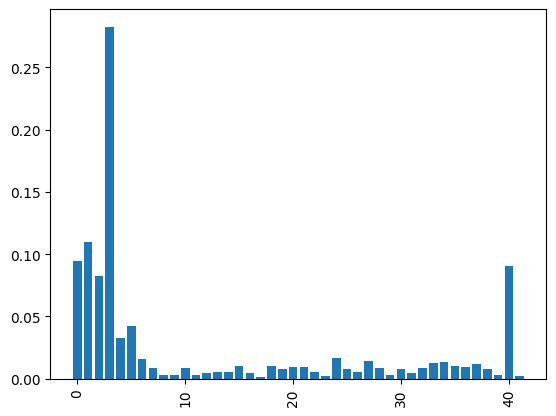

In [94]:
plt.bar(x = np.arange(42),height=clf.feature_importances_)
plt.xticks(rotation = 90)
plt.show()

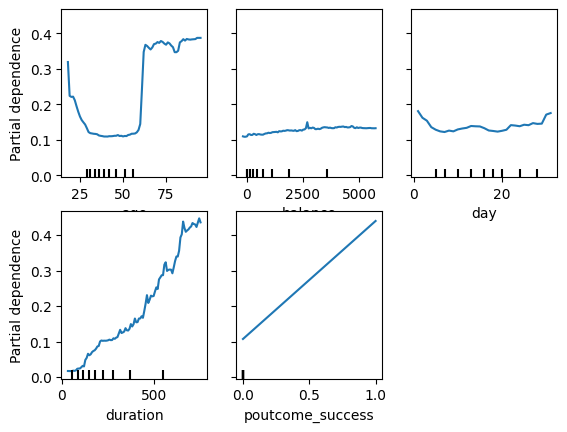

In [96]:
from sklearn.inspection import PartialDependenceDisplay

features = [0,1,2,3,40]
PartialDependenceDisplay.from_estimator(clf, xtrain, features)

I chose the random forest model because it had a higher oob accuracy. The five most important variables were age, balance, day, duration, and poutcome_success. Balance,, and poutcome_success have a linear relationship. Where as with age, middle ages have lower dependency value than younger and elderly people. You would want to call at the beginning of the week to younger or older clients who have balance between 2500 and 5000 and who you are able to talk with the longest. You would also want to talk with those who were successful outcomes on the previous marketing campaign. 